# Klasifikasi Berita Hoax

[Data](https://www.kaggle.com/muhammadghazimuharam/indonesiafalsenews)

[Referensi](https://www.kaggle.com/muhammadghazimuharam/machine-learning-for-hoax-text-classification)

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'fadhlanmr'
os.environ['KAGGLE_KEY'] = '319f4074bc68590816a9096daa22729e'

In [ ]:
! pip install kaggle -q

In [ ]:
!pip install PySastrawi

     |████████████████████████████████| 215kB 6.8MB/s 


In [ ]:
! kaggle datasets download -d muhammadghazimuharam/indonesiafalsenews
! rm -rf indonesiafalsenews
! unzip indonesiafalsenews.zip > /dev/null

  0% 0.00/548k [00:00<?, ?B/s]
100% 548k/548k [00:00<00:00, 37.5MB/s]


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import os, re, time
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, Normalizer, normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from tensorflow import keras
from keras.optimizers import Adam

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

Input Data Latih

In [ ]:
path = 'Data_latih.csv'
dataframe = pd.read_csv(path)
dataframe

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg
...,...,...,...,...,...,...
4226,999287,1,17-Jan-16,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...,999287.jpg
4227,999472,1,20-Aug-20,Foto pejabat keuangan dibawah palu arit,Jangan mau dialihkan kepada pakaian adat… FOKU...,999472.png
4228,999501,1,17-Aug-20,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,Akhir nya bisa terkenal bang denny,999501.jpg
4229,999848,1,21-Jul-20,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...,999848.jpg


Input Data Uji

In [ ]:
path_uji = 'Data_uji.csv'
Data_uji = pd.read_csv(path_uji)
data_uji = Data_uji.loc[:, ['narasi']]
data_uji['label'] = np.nan 
data_uji

,narasi,label
0,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...,NaN
1,Seberat beratnya Pekerjaan Akan terasa ringan ...,NaN
2,Hindu di india melemparkan patung buatan merek...,NaN
3,Mulai Hari ini di RSCM mulai diPraktekkan Peny...,NaN
4,"Untuk sekedar info, Bagi anda yg punya ansuran...",NaN
...,...,...
465,"DiTangerang, dua bersaudara kakak beradik usia...",NaN
466,"Pertanda Alam, Kera Putih Mulai Turun Dari Gun...",NaN
467,Assalamu Alaikum …\n \n Info dari pedagang pa...,NaN
468,Secara tidak sengaja sekitar pukul 06.00 WIB d...,NaN


Mengambil kolom 'narasi' dan 'label'

In [ ]:
dataframe = dataframe.loc[:, ['narasi', 'label']]

In [ ]:
dataB = dataframe.copy

In [ ]:
feature = dataframe['narasi']
label = dataframe['label']

Cek missing value

In [ ]:
print(" \nCount total NaN in Data : \n\n",
       dataframe.isnull().sum().sum())

 
Count total NaN in Data : 

 0


Cek data duplikat

In [ ]:
dup = dataframe.duplicated().any() 
print(dup)
dupSum = dataframe.duplicated().sum()
print(dupSum)

True
20


In [ ]:
dup_test = data_uji.duplicated().any() 
print(dup_test)
dupSum_test = data_uji.duplicated().sum()
print(dupSum_test)

True
1


data duplikat pada data latih

In [ ]:
dataframe.loc[dataframe.duplicated(), :]

,narasi,label
427,5G antenna inside of your masks,1
497,PERKENALKAN: ALL JAKARTA WATER PARK,1
812,"INSTING MAKELAR\n \n AKU Awalnya kaget, membac...",0
892,CORONA IS A HOAX,1
1344,Perhatian perhatian Sekarang malesiya makin da...,1
1632,Cek tangkapan layar.,1
1776,Cek tangkapan layar.,1
1777,Cek tangkapan layar,1
2103,Weird things happening at deserted Japani park...,1
2501,A Queensland Health spokeswoman said the actor...,1


In [ ]:
#df.drop_duplicates(inplace=True)

# Preprocessing

stemming bahasa indonesia untuk menghilangkan kata imbuhan

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from spacy.lang.id import Indonesian

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
spacy_id = Indonesian()

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

membersihkan simbol dan spasi

In [ ]:
def cleaning(document):
    sents = sent_tokenize(document)
    sents_tok = list() # tokenisasi kalimat
    for s in sents:
        s = s.strip().lower()
        s = s.replace("the", " ") # menghapus kata the
        s = s.replace("yg", " ") # menhapus kata yg
        s = s.replace("\n", " ") # menggantikan \n dengan spasi
        s = re.sub(r'[^a-zA-Z0-9 ]', '', s) # menghapus simbol
        s = re.sub(' +', ' ', s) # menghapus repetitive space

        sents_tok.append(s)
    return " ".join(sents_tok)

stopword bahasa indonesia

In [ ]:
nltk_stw_id = stopwords.words('indonesian')
sastrawi_stw_id = StopWordRemoverFactory().get_stop_words()
stw_id = set(sastrawi_stw_id+nltk_stw_id)

def remove_stw(doc):
    out = []
    sents = [token.text for token in spacy_id(doc)]
    for txt in sents:
        if txt in stw_id:
            continue
        out.append(txt)
    return ' '.join(out)

In [ ]:
dataframe['narasi'] = dataframe['narasi'].apply(cleaning).apply(stemmer.stem).apply(remove_stw)
dataframe['narasi'].to_numpy()[:20]

array(['caller to radio talk show recently shared that his wife was hospitalized told she had covid only couple of days left to live doctor friend suggested she be tested for legionnaires disease because she wore same mask every day all day long turns out it was legionnaires disease from moisture bacteria in her mask she was given antibiotics within two days was better what if spikes in covid are really something else due to mask induced infections',
       'ythseluruh anggota grup sesuai instruksi gubernur jawa hasil rapat tim gugus tugas covid 19 jateng sbb',
       'jokowi presiden dlm sejarah bangsa indonesia jim rohn motivator dunia',
       'maaf mas2 mbak2 politik jokowi hasil pulang 11000 triliun uang negara swiss 11 ribu triliun bawa indonesiaruu treaty on mutual legal assistance in criminal matters between republic of indonesia and swiss confederation mla riswiss resmi sah dpr ri tanggal 3 juli 2020 proses konstitusi tarik dana swiss selesai juang ex koruptor bersenggama agam

In [ ]:
data_uji['narasi'] = data_uji['narasi'].apply(cleaning).apply(stemmer.stem).apply(remove_stw)

In [ ]:
dataframe['narasi']

0       caller to radio talk show recently shared that...
1       ythseluruh anggota grup sesuai instruksi guber...
2       jokowi presiden dlm sejarah bangsa indonesia j...
3       maaf mas2 mbak2 politik jokowi hasil pulang 11...
4                           kadrun kalo foto panas dingin
                              ...                        
4226            kpk larang bawa brimob senjata gedung dpr
4227    alih pakai adat fokus isyarat commune sandi ko...
4228                                     kenal bang denny
4229                    kesederhaan nipu rakyat indonesia
4230    in nolak periksa periksa kepala periksa punggu...
Name: narasi, Length: 4231, dtype: object

pembuatan token

In [ ]:
tokens = [word_tokenize(element) for element in dataframe['narasi']]
tokens_uji = [word_tokenize(element) for element in data_uji['narasi']]
# Hasil tokenisasi
print(len(tokens))
list(tokens[1])

4231


['ythseluruh',
 'anggota',
 'grup',
 'sesuai',
 'instruksi',
 'gubernur',
 'jawa',
 'hasil',
 'rapat',
 'tim',
 'gugus',
 'tugas',
 'covid',
 '19',
 'jateng',
 'sbb']

pengaplikasian bigram

In [ ]:
bigram = [ngrams(tokens, 2)]
list(nltk.bigrams(tokens[1]))

[('ythseluruh', 'anggota'),
 ('anggota', 'grup'),
 ('grup', 'sesuai'),
 ('sesuai', 'instruksi'),
 ('instruksi', 'gubernur'),
 ('gubernur', 'jawa'),
 ('jawa', 'hasil'),
 ('hasil', 'rapat'),
 ('rapat', 'tim'),
 ('tim', 'gugus'),
 ('gugus', 'tugas'),
 ('tugas', 'covid'),
 ('covid', '19'),
 ('19', 'jateng'),
 ('jateng', 'sbb')]

penghitungan word frequency

In [ ]:
wordcount = {}
counting = 0
for number in tokens:
  counted = len(tokens[counting])
  for words in tokens[counting]:
    if words not in wordcount:
      wordcount[words] = 1
    else:
      wordcount[words] += 1
  counting+=1
print(wordcount)

{'caller': 1, 'to': 100, 'radio': 2, 'talk': 1, 'show': 4, 'recently': 3, 'shared': 2, 'that': 30, 'his': 14, 'wife': 4, 'was': 24, 'hospitalized': 1, 'told': 2, 'she': 7, 'had': 10, 'covid': 86, 'only': 5, 'couple': 2, 'of': 116, 'days': 7, 'left': 7, 'live': 5, 'doctor': 5, 'friend': 1, 'suggested': 1, 'be': 22, 'tested': 3, 'for': 39, 'legionnaires': 3, 'disease': 6, 'because': 8, 'wore': 1, 'same': 4, 'mask': 8, 'every': 2, 'day': 4, 'all': 14, 'long': 4, 'turns': 2, 'out': 18, 'it': 35, 'from': 27, 'moisture': 1, 'bacteria': 3, 'in': 107, 'her': 10, 'given': 1, 'antibiotics': 2, 'within': 2, 'two': 3, 'better': 2, 'what': 5, 'if': 8, 'spikes': 1, 'are': 21, 'really': 7, 'something': 2, 'else': 1, 'due': 8, 'induced': 1, 'infections': 1, 'ythseluruh': 2, 'anggota': 76, 'grup': 25, 'sesuai': 40, 'instruksi': 10, 'gubernur': 68, 'jawa': 65, 'hasil': 119, 'rapat': 37, 'tim': 46, 'gugus': 3, 'tugas': 48, '19': 76, 'jateng': 5, 'sbb': 6, 'jokowi': 301, 'presiden': 203, 'dlm': 43, 'sejar

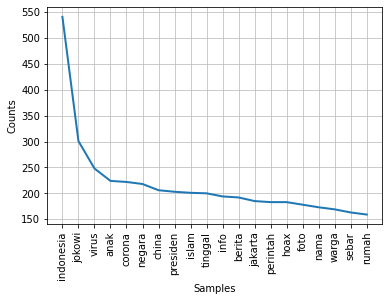

In [ ]:
fdist = nltk.FreqDist(wordcount)
fdist.plot(20)

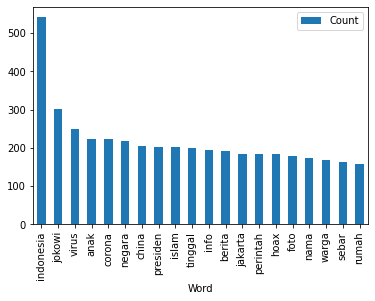

In [ ]:
import collections
word_counter = collections.Counter(wordcount)
lst = word_counter.most_common(20)
plot_token = pd.DataFrame(lst, columns = ['Word', 'Count'])
plot_token.plot.bar(x='Word',y='Count')

splitting data uji dan data validasi

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tokens, label, test_size=0.2, stratify=label)

aplikasi tfidf-vectorizer

In [ ]:
Tfidf = TfidfVectorizer(binary=True)
Tfidf.fit(["".join(row) for row in X_train])

x = Tfidf.transform([" ".join(row) for row in X_train])
x = x.astype('float16')
x_test = Tfidf.transform([" ".join(row) for row in X_test])
x_test = x_test.astype('float16')

In [ ]:
print(x.shape)
print(label.shape)

(3384, 3362)
(4231,)


encoding label dan mengubah menjadi tensor kategori

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(label)
y = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Simple NN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              3363000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2002      
Total params: 4,366,002
Trainable params: 4,366,002
Non-trainable params: 0
_________________________________________________________________


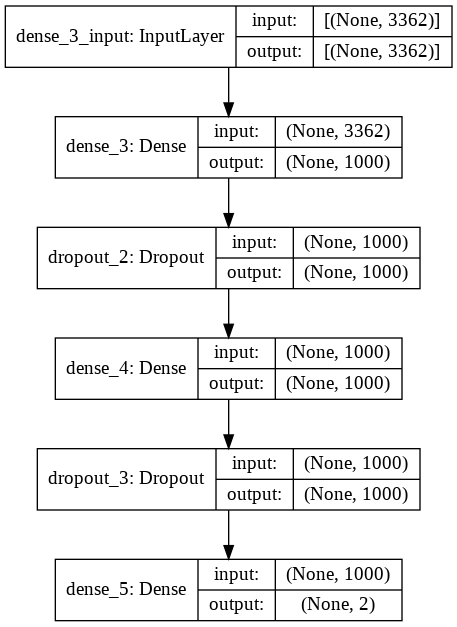

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(1000, activation='relu', input_dim=3362))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x, y, epochs=20, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape:0", shape=(None, 1000), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


7/7 [==============================] - 2s 130ms/step - loss: 0.6903 - accuracy: 0.7246 - val_loss: 0.6868 - val_accuracy: 0.8194
Epoch 2/20
7/7 [==============================] - 1s 104ms/step - loss: 0.6825 - accuracy: 0.8191 - val_loss: 0.6785 - val_accuracy: 0.8194
Epoch 3/20
7/7 [==============================] - 1s 105ms/step - loss: 0.6726 - accuracy: 0.8189 - val_loss: 0.6679 - val_accuracy: 0.8194
Epoch 4/20
7/7 [==============================] - 1s 99ms/step - loss: 0.6601 - accuracy: 0.8189 - val_loss: 0.6542 - val_accuracy: 0.8194
Epoch 5/20
7/7 [==============================] - 1s 101ms/step - loss: 0.6437 - accuracy: 0.8189 - val_loss: 0.6369 - val_accuracy: 0.8194
Epoch 6/20
7/7 [==============================] - 1s 101ms/step - loss: 0.6241 - accuracy: 0.8189 - val_loss: 0.6158 - val_accuracy: 0.8194
Epoch 7/20
7/7 [==============================] - 1s 98ms/step - loss: 0.6009 - accuracy: 0.8189 - val_loss: 0.5913 - val_accuracy: 0.8194
Epoch 8/20
7/7 [=================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


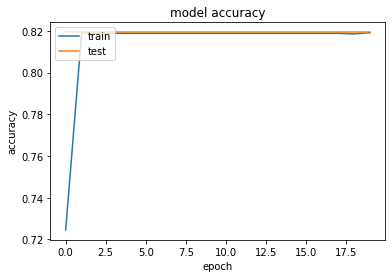

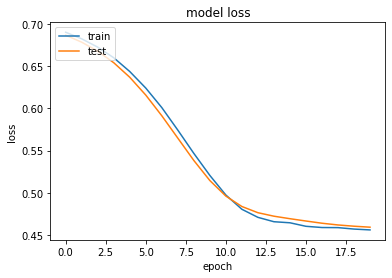

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

27/27 - 0s - loss: 0.4590 - accuracy: 0.8194

Test accuracy: 0.819362461566925


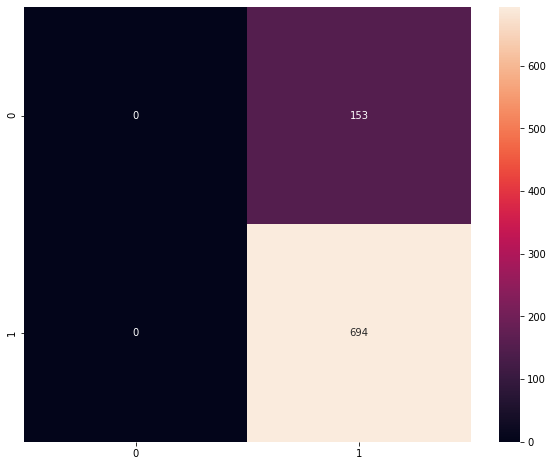

In [ ]:
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis = 1)
y_true = np.argmax(y_test, axis = 1) 

confusion_mtx = confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.82      1.00      0.90       694

    accuracy                           0.82       847
   macro avg       0.41      0.50      0.45       847
weighted avg       0.67      0.82      0.74       847



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x_uji = Tfidf.transform([" ".join(row) for row in tokens_uji])
x_uji = x_uji.astype('float16')

In [ ]:
preds = model.predict(x_uji)

In [ ]:
data_uji['label'] = ['Hoax' if x > 0 else 'Not Hoax' for x in preds[:, 0]]

In [ ]:
data_uji.head(20)

,narasi,label
0,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...,Hoax
1,Seberat beratnya Pekerjaan Akan terasa ringan ...,Hoax
2,Hindu di india melemparkan patung buatan merek...,Hoax
3,Mulai Hari ini di RSCM mulai diPraktekkan Peny...,Hoax
4,"Untuk sekedar info, Bagi anda yg punya ansuran...",Hoax
5,Assalamua’laikum warahmatullahi wabarakatuh.\n...,Hoax
6,Malam ini 00:30-03:30 pastikan untuk mematikan...,Hoax
7,Lokasi di SMKN 12 Jakarta Utara. Sekolah Neger...,Hoax
8,PARAH…MEMAKSAKAN HAL YANG TAK WAJAR TERUS DILA...,Hoax
9,BREAKING: Daniel Radcliffe test posotive for c...,Hoax


In [ ]:
data_uji.loc[data_uji['label'] == 'Not Hoax']

,narasi,label


## SVM

In [ ]:
y = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=1, gamma="auto", verbose=True)
SVM.fit(x, y)  # predict the labels on validation dataset

predictions_SVM = SVM.predict(x_test)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test)*100)

[LibSVM]SVM Accuracy Score ->  81.58205430932703


Test Accuracy = 0.82


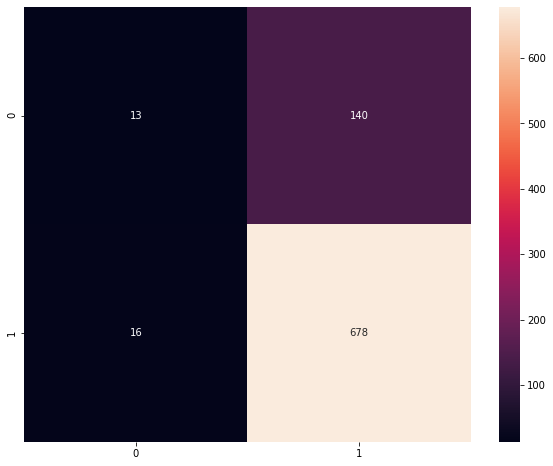

In [ ]:
predictions = [1 if x>0 else 0 for x in predictions_SVM]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.45      0.08      0.14       153
           1       0.83      0.98      0.90       694

    accuracy                           0.82       847
   macro avg       0.64      0.53      0.52       847
weighted avg       0.76      0.82      0.76       847



## Simple NN w/ Bigram

In [ ]:
X_bigram, X_biv, y_bigram, y_biv = train_test_split(tokens, label, test_size=0.2, stratify=label)

In [ ]:
bigram_counter = CountVectorizer(ngram_range=(2, 2))

X_bigram = bigram_counter.fit_transform([" ".join(row) for row in X_bigram])
X_biv  = bigram_counter.transform([" ".join(row) for row in X_biv])

X_bigram = X_bigram.astype('float16')
X_biv = X_biv.astype('float16')

In [ ]:
bigram_shape = np.arange(1, 3385)

In [ ]:
print(X_bigram.shape)
print(label.shape)
#print(bigram_shape.shape)

(3384, 44406)
(4231,)


In [ ]:
lb = LabelEncoder()
#y_bigram = lb.fit_transform(bigram_shape)
y_big_train = np.asarray(y_bigram).astype('float32').reshape((-1,1))
y_big_test = np.asarray(y_biv).astype('float32').reshape((-1,1))
y_big_train = keras.utils.to_categorical(y_big_train)
y_big_test = keras.utils.to_categorical(y_big_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1000)              44407000  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 2002      
Total params: 45,410,002
Trainable params: 45,410,002
Non-trainable params: 0
_________________________________________________________________


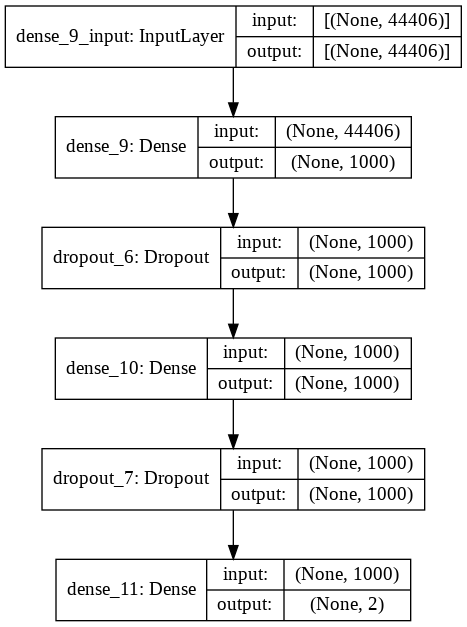

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(1000, activation='relu', input_dim=44406))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history_bi = model.fit(X_bigram, y_big_train, epochs=20, batch_size=512, validation_data=(X_biv, y_big_test))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_3/dense_9/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_3/dense_9/embedding_lookup_sparse/Reshape:0", shape=(None, 1000), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/dense_9/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


7/7 [==============================] - 5s 609ms/step - loss: 0.6858 - accuracy: 0.6528 - val_loss: 0.6800 - val_accuracy: 0.8194
Epoch 2/20
7/7 [==============================] - 4s 577ms/step - loss: 0.6509 - accuracy: 0.8189 - val_loss: 0.6648 - val_accuracy: 0.8194
Epoch 3/20
7/7 [==============================] - 4s 573ms/step - loss: 0.6154 - accuracy: 0.8189 - val_loss: 0.6472 - val_accuracy: 0.8194
Epoch 4/20
7/7 [==============================] - 4s 576ms/step - loss: 0.5767 - accuracy: 0.8189 - val_loss: 0.6266 - val_accuracy: 0.8194
Epoch 5/20
7/7 [==============================] - 4s 568ms/step - loss: 0.5312 - accuracy: 0.8189 - val_loss: 0.6029 - val_accuracy: 0.8194
Epoch 6/20
7/7 [==============================] - 4s 576ms/step - loss: 0.4834 - accuracy: 0.8189 - val_loss: 0.5769 - val_accuracy: 0.8194
Epoch 7/20
7/7 [==============================] - 4s 577ms/step - loss: 0.4337 - accuracy: 0.8189 - val_loss: 0.5505 - val_accuracy: 0.8194
Epoch 8/20
7/7 [===============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


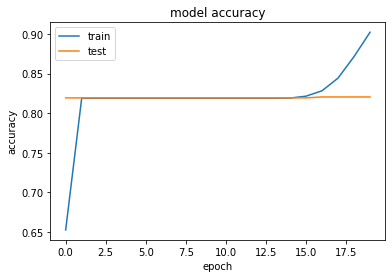

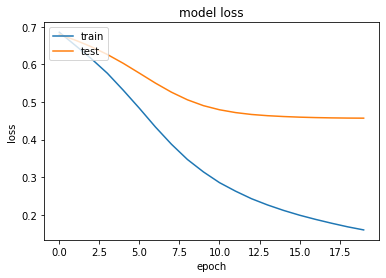

In [ ]:
print(history_bi.history.keys())
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_biv,  y_big_test, verbose=2)

print('\nTest accuracy:', test_acc)

27/27 - 0s - loss: 0.4571 - accuracy: 0.8205

Test accuracy: 0.820543110370636


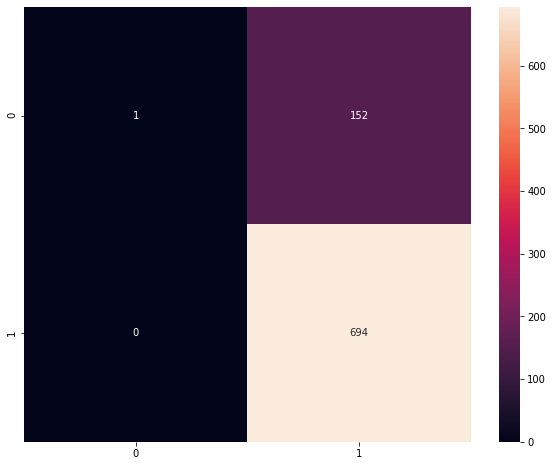

In [ ]:
predictions_bi = model.predict(X_biv)
y_pred_bi = np.argmax(predictions_bi, axis = 1)
y_true_bi = np.argmax(y_big_test, axis = 1) 

confusion_mtx = confusion_matrix(y_true_bi, y_pred_bi) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [ ]:
print(classification_report(y_true_bi, y_pred_bi))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       153
           1       0.82      1.00      0.90       694

    accuracy                           0.82       847
   macro avg       0.91      0.50      0.46       847
weighted avg       0.85      0.82      0.74       847



## SVM w/ Bigram

In [ ]:
y_bigram = lb.fit_transform(y_bigram)
y_biv = lb.fit_transform(y_biv)

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=1, gamma="auto", verbose=True)
SVM.fit(X_bigram, y_bigram)  # predict the labels on validation dataset

predictions_SVM = SVM.predict(X_biv)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_biv)*100)

[LibSVM]SVM Accuracy Score ->  82.0543093270366


Test Accuracy = 0.82


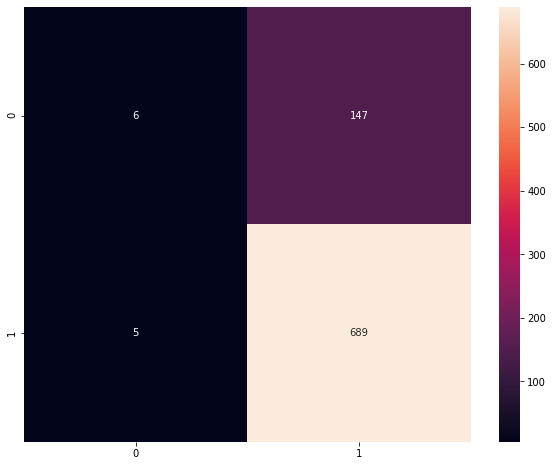

In [ ]:
predictions_SVM = [1 if x>0 else 0 for x in predictions_SVM]

accuracy = accuracy_score(y_biv, predictions_SVM)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_biv, predictions_SVM) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [ ]:
print(classification_report(y_biv, predictions_SVM))

              precision    recall  f1-score   support

           0       0.55      0.04      0.07       153
           1       0.82      0.99      0.90       694

    accuracy                           0.82       847
   macro avg       0.68      0.52      0.49       847
weighted avg       0.77      0.82      0.75       847

